## IMPORTS & DRY CODE

# LOAD DATA INTO MEMORY

In [65]:
# RUN ONCE, REST OF CODE SHOULD WORK
%matplotlib inline
from matplotlib import pyplot as plt

import scipy
from scipy import ndimage, signal

import scipy.spatial.distance as distance
from scipy.spatial.distance import euclidean,pdist, squareform, cdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import numpy as np
from numpy.lib.stride_tricks import as_strided
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

import pandas as pd
import glob, os, json, platform, cvxopt

import cvxEDA as eda
import pylab as pl

from pprint import pprint

def save_jsonfile(fn, data):
    file = fn
    with open(file, 'w') as outfile:
        json.dump(data, outfile)
    print("File saved!", file)
    
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

# DISTANCE METRICS
# Similarity Distance
def EuclideanDistance(t1, t2):
    return np.sqrt(np.sum((t1-t2)**2))

# Dynamic Time Warping Distance
def DTWDistance(s1, s2):
    # Initialize distance matrix (nxn), pad filling with inf  
    DTW= {}
    n1 = range(len(s1))
    n2 = range(len(s2))
    for i in n1:
        DTW[(i, -1)] = float('inf')
    for i in n2:
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0
    
    # Compute the distances (O(nm) time)
    for i in n1:
        for j in n2:
            dist = (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)], DTW[(i, j-1)], DTW[(i-1, j-1)])
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

def subsequences(arr, L):
    n = arr.size - (L -1)
    s = arr.itemsize
    return as_strided(arr, shape=(n,L), strides=(s,s))


In [66]:
# %load cvxEDA.py
"""
______________________________________________________________________________

 File:                         cvxEDA.py
 Last revised:                 07 Nov 2015 r69
 ______________________________________________________________________________

 Copyright (C) 2014-2015 Luca Citi, Alberto Greco
 
 This program is free software; you can redistribute it and/or modify it under
 the terms of the GNU General Public License as published by the Free Software
 Foundation; either version 3 of the License, or (at your option) any later
 version.
 
 This program is distributed in the hope that it will be useful, but WITHOUT
 ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS
 FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.
 
 You may contact the author by e-mail (lciti@ieee.org).
 ______________________________________________________________________________

 This method was first proposed in:
 A Greco, G Valenza, A Lanata, EP Scilingo, and L Citi
 "cvxEDA: a Convex Optimization Approach to Electrodermal Activity Processing"
 IEEE Transactions on Biomedical Engineering, 2015
 DOI: 10.1109/TBME.2015.2474131

 If you use this program in support of published research, please include a
 citation of the reference above. If you use this code in a software package,
 please explicitly inform the end users of this copyright notice and ask them
 to cite the reference above in their published research.
 ______________________________________________________________________________
"""

import numpy as np
import cvxopt as cv
import cvxopt.solvers

def cvxEDA(y, delta, tau0=2., tau1=0.7, delta_knot=10., alpha=8e-4, gamma=1e-2,
           solver=None, options={'reltol':1e-9}):
    """CVXEDA Convex optimization approach to electrodermal activity processing

    This function implements the cvxEDA algorithm described in "cvxEDA: a
    Convex Optimization Approach to Electrodermal Activity Processing"
    (http://dx.doi.org/10.1109/TBME.2015.2474131, also available from the
    authors' homepages).

    Arguments:
       y: observed EDA signal (we recommend normalizing it: y = zscore(y))
       delta: sampling interval (in seconds) of y
       tau0: slow time constant of the Bateman function
       tau1: fast time constant of the Bateman function
       delta_knot: time between knots of the tonic spline function
       alpha: penalization for the sparse SMNA driver
       gamma: penalization for the tonic spline coefficients
       solver: sparse QP solver to be used, see cvxopt.solvers.qp
       options: solver options, see:
                http://cvxopt.org/userguide/coneprog.html#algorithm-parameters

    Returns (see paper for details):
       r: phasic component
       p: sparse SMNA driver of phasic component
       t: tonic component
       l: coefficients of tonic spline
       d: offset and slope of the linear drift term
       e: model residuals
       obj: value of objective function being minimized (eq 15 of paper)
    """

    n = len(y)
    y = cv.matrix(y)

    # bateman ARMA model
    a1 = 1./min(tau1, tau0) # a1 > a0
    a0 = 1./max(tau1, tau0)
    ar = np.array([(a1*delta + 2.) * (a0*delta + 2.), 2.*a1*a0*delta**2 - 8.,
        (a1*delta - 2.) * (a0*delta - 2.)]) / ((a1 - a0) * delta**2)
    ma = np.array([1., 2., 1.])

    # matrices for ARMA model
    i = np.arange(2, n)
    A = cv.spmatrix(np.tile(ar, (n-2,1)), np.c_[i,i,i], np.c_[i,i-1,i-2], (n,n))
    M = cv.spmatrix(np.tile(ma, (n-2,1)), np.c_[i,i,i], np.c_[i,i-1,i-2], (n,n))

    # spline
    delta_knot_s = int(round(delta_knot / delta))
    spl = np.r_[np.arange(1.,delta_knot_s), np.arange(delta_knot_s, 0., -1.)] # order 1
    spl = np.convolve(spl, spl, 'full')
    spl /= max(spl)
    # matrix of spline regressors
    i = np.c_[np.arange(-(len(spl)//2), (len(spl)+1)//2)] + np.r_[np.arange(0, n, delta_knot_s)]
    nB = i.shape[1]
    j = np.tile(np.arange(nB), (len(spl),1))
    p = np.tile(spl, (nB,1)).T
    valid = (i >= 0) & (i < n)
    B = cv.spmatrix(p[valid], i[valid], j[valid])

    # trend
    C = cv.matrix(np.c_[np.ones(n), np.arange(1., n+1.)/n])
    nC = C.size[1]

    # Solve the problem:
    # .5*(M*q + B*l + C*d - y)^2 + alpha*sum(A,1)*p + .5*gamma*l'*l
    # s.t. A*q >= 0

    old_options = cv.solvers.options.copy()
    cv.solvers.options.clear()
    cv.solvers.options.update(options)
    if solver == 'conelp':
        # Use conelp
        z = lambda m,n: cv.spmatrix([],[],[],(m,n))
        G = cv.sparse([[-A,z(2,n),M,z(nB+2,n)],[z(n+2,nC),C,z(nB+2,nC)],
                    [z(n,1),-1,1,z(n+nB+2,1)],[z(2*n+2,1),-1,1,z(nB,1)],
                    [z(n+2,nB),B,z(2,nB),cv.spmatrix(1.0, range(nB), range(nB))]])
        h = cv.matrix([z(n,1),.5,.5,y,.5,.5,z(nB,1)])
        c = cv.matrix([(cv.matrix(alpha, (1,n)) * A).T,z(nC,1),1,gamma,z(nB,1)])
        res = cv.solvers.conelp(c, G, h, dims={'l':n,'q':[n+2,nB+2],'s':[]})
        obj = res['primal objective']
    else:
        # Use qp
        Mt, Ct, Bt = M.T, C.T, B.T
        H = cv.sparse([[Mt*M, Ct*M, Bt*M], [Mt*C, Ct*C, Bt*C], 
                    [Mt*B, Ct*B, Bt*B+gamma*cv.spmatrix(1.0, range(nB), range(nB))]])
        f = cv.matrix([(cv.matrix(alpha, (1,n)) * A).T - Mt*y,  -(Ct*y), -(Bt*y)])
        res = cv.solvers.qp(H, f, cv.spmatrix(-A.V, A.I, A.J, (n,len(f))),
                            cv.matrix(0., (n,1)), solver=solver)
        obj = res['primal objective'] + .5 * (y.T * y)
    cv.solvers.options.clear()
    cv.solvers.options.update(old_options)

    l = res['x'][-nB:]
    d = res['x'][n:n+nC]
    t = B*l + C*d
    q = res['x'][:n]
    p = A * q
    r = M * q
    e = y - r - t

    return (np.array(a).ravel() for a in (r, p, t, l, d, e, obj))


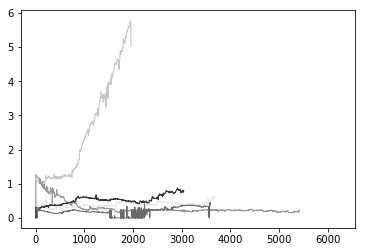

[array([ 0.     ,  0.83276,  1.17639, ...,  0.33472,  0.11685,  0.11173]), array([ 0.     ,  0.30366,  0.37413, ...,  0.56786,  0.6063 ,  0.61014]), array([ 0.     ,  0.83276,  1.10208, ...,  5.70156,  5.30055,  5.02125]), array([ 0.     ,  0.83276,  1.17767, ...,  0.21551,  0.23088,  0.23216]), array([ 0.     ,  0.17554,  0.21654, ...,  0.45487,  0.45487,  0.45359]), array([ 0.     ,  0.23319,  0.30238, ...,  0.76389,  0.78568,  0.79208])]


In [82]:
# Graph should look like: 
# x-axis: time, starting from 0, increment by 4. Range is [0, size of data array/4]
# y-axis: the data (would be a lot better cropped according to the videos); 

DATA_DIRECTORY = "data"
PROCESS_PREFIX = "EDA*"
files = glob.glob("/".join([DATA_DIRECTORY, PROCESS_PREFIX]))

manifest = []

pos = 0
for path in files:
    k = pos/len(files)
    pos = pos + 1
    
    name = os.path.basename(path)
    f = open(path)
    data = json.load(f)["data"]
    f.close()
    
    array_size = len(data)
    y = [float(i) for i in data]
    y = np.array(y)
    
    manifest.append(y)
    plt.plot(y, color=plt.cm.Greys(k), lw=1)
    
# TOGGLE TO VIEW RAW DATA
plt.show()
# plt.close()
print(manifest)

     pcost       dcost       gap    pres   dres
 0: -3.0242e+03 -2.9651e+03  1e+04  1e+02  5e-01
 1: -3.0589e+03 -4.9583e+03  2e+03  2e+01  7e-02
 2: -3.0882e+03 -3.8396e+03  8e+02  6e+00  2e-02
 3: -3.0992e+03 -3.4110e+03  3e+02  2e+00  7e-03
 4: -3.1027e+03 -3.2348e+03  1e+02  6e-01  2e-03
 5: -3.1049e+03 -3.1521e+03  5e+01  2e-01  7e-04
 6: -3.1087e+03 -3.1199e+03  1e+01  2e-02  8e-05
 7: -3.1121e+03 -3.1162e+03  4e+00  6e-03  2e-05
 8: -3.1136e+03 -3.1150e+03  1e+00  1e-03  4e-06
 9: -3.1141e+03 -3.1147e+03  6e-01  3e-04  9e-07
10: -3.1143e+03 -3.1145e+03  2e-01  4e-05  1e-07
11: -3.1144e+03 -3.1144e+03  5e-02  6e-06  2e-08
12: -3.1144e+03 -3.1144e+03  1e-02  9e-07  3e-09
13: -3.1144e+03 -3.1144e+03  3e-03  2e-07  6e-10
14: -3.1144e+03 -3.1144e+03  7e-04  3e-08  1e-10
15: -3.1144e+03 -3.1144e+03  1e-04  3e-09  1e-11
16: -3.1144e+03 -3.1144e+03  3e-05  4e-10  1e-12
17: -3.1144e+03 -3.1144e+03  3e-06  4e-11  2e-13
18: -3.1144e+03 -3.1144e+03  1e-07  1e-12  5e-14
Optimal solution foun

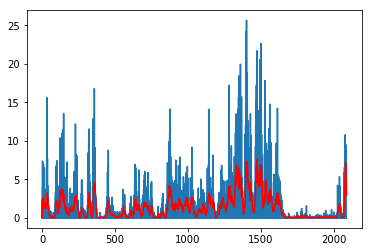

In [88]:
# EDA ANALYSIS
# r: phasic component
# p: sparse SMNA driver of phasic component
# t: tonic component
# l: coefficients of tonic spline
# d: offset and slope of the linear drift term
# e: model residuals
# obj: value of objective function being minimized (eq 15 of paper)

y = manifest[0]
yn = (y - y.mean()) / y.std()
Fs = 3.


[r, p, t, l, d, e, obj] = eda.cvxEDA(yn, 1./Fs)

tm = pl.arange(1., len(y)+1.) / Fs
# pl.hold(True)
# pl.plot(tm, yn)
pl.plot(tm, p)
pl.plot(tm, r, 'r')


pl.show()

## PROCESS DATA

In [39]:
pos = 0
for i in manifest:
    pt = manifest[i]
    k = pos/len(files)
    pos = pos + 1
    
    
    manifest[i]["y_gauss"] = y_gauss
    
    maximum = np.max(y_gauss)

    

# for key in smoothed:
#     values = smoothed[key]
#     minimum = min(values)
#     maximum = max(values)
#     ran = maximum - minimum
#     for i in range(len(values)):
#         values[i] = (values[i] - minimum) / ran
        
# save_jsonfile("data/normalized_EDA.json", smoothed)

# # Detrend the data 
# f = open("data/normalized_EDA.json")
# normalized = json.load(f)
# f.close

# for key in normalized:
#     values = normalized[key]
#     values = signal.detrend(values)

# save_jsonfile("data/detrended_EDA.json", normalized)
    
# # plot the smoothed, normalized, detrended data
# f = open("data/detrended_EDA.json")
# detrended = json.load(f)
# f.close

# for key in detrended:
#     values = detrended[key]
#     # Artificial time array
#     array_size = len(values)
#     t = [int(x/4) for x in range(array_size)]
#     plt.plot(t, values, 'g-', lw=1)



# # Artificial time array
# array_size = len(data)
# print(array_size)
# t = [int(x/4) for x in range(array_size)]

# # Convert string elements in data into floats
# y = [float(i) for i in data]

# # Plot
# plt.plot(t, y, 'g-', lw=1)
# # Play around with the second parameter to increase smoothing of the curve
# y_gauss = scipy.ndimage.filters.gaussian_filter1d(y, 99.0, axis=-1, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)
# plt.plot(t, y_gauss, 'b-', lw=2)
# print(max(y_gauss))
# y_gauss = y

TypeError: only integer arrays with one element can be converted to an index

In [6]:
t = data['time']
y = data['data'][0]
plt.plot(t, y, 'g-', lw=1)
y_gauss = scipy.ndimage.filters.gaussian_filter1d(y, 3.0, axis=-1, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)
plt.plot(t, y_gauss, 'b-', lw=2)
y_gauss = y

TypeError: list indices must be integers or slices, not str

## K-center clustering

In [25]:
# Divide into sub-sections of 7 seconds
SF = 4 # sampling frequency = 4 Hz
L = 7 * SF 
TH = 0.3

combined_ss = []
for key in detrended:
    data = np.array(detrended[key])
    ss = subsequences(data, L)
    print(key,"/",len(detrended), ":", len(combined_ss), "<<", ss.shape)
    combined_ss.extend(ss)
final = np.matrix(combined_ss)
print(final)
dimension = final.shape

1 / 6 : 0 << (6231, 28)
2 / 6 : 6231 << (3561, 28)
3 / 6 : 9792 << (3015, 28)
4 / 6 : 12807 << (1929, 28)
5 / 6 : 14736 << (5391, 28)
6 / 6 : 20127 << (3657, 28)
[[0.23536 0.23538 0.2354  ... 0.23972 0.24007 0.24042]
 [0.23538 0.2354  0.23544 ... 0.24007 0.24042 0.24079]
 [0.2354  0.23544 0.2355  ... 0.24042 0.24079 0.24118]
 ...
 [0.98816 0.98894 0.9897  ... 0.99972 0.99983 0.99992]
 [0.98894 0.9897  0.99042 ... 0.99983 0.99992 0.99997]
 [0.9897  0.99042 0.99113 ... 0.99992 0.99997 1.     ]]


In [31]:
%%time
arr = np.ones(dimension)
k = []
k.append(final[0])

arr = np.multiply(arr, k[0])
diff= np.subtract(final, arr)
# print(k[0])
most_diff = np.max([sum(sub) for sub in diff])
print(most_diff)

0.7646372449657315
CPU times: user 451 ms, sys: 191 ms, total: 642 ms
Wall time: 741 ms


In [63]:
# Emily Clustering Playground

# To find the most different one:
# fill another array with all the subarrays of array[0]
# subtract two arrays
# and np.max() to find the most different one

different = []
dummy = [combined_ss[0] for subarray in combined_ss]
different = [DTWDistance(combined_ss[i], dummy[i]) for i in range(len(dummy) + 1)]
most_different = different.index(np.max(different))
print(most_different)

NameError: name 'combined_ss' is not defined

In [64]:
# small = np.ones((1000000, 28))
small = combined_ss
arr = np.ones((len(small), 28))
k = []
k.append(small[0])

arr = np.multiply(arr, k[0])
diff= np.subtract(arr, small)
# print(k[0])
print(diff)

NameError: name 'combined_ss' is not defined

In [9]:
def check_different(array):
    i = 0
    while i < len(array):
        j = i + 1
        while j < len(array):
            if DTWDistance(array[i], array[j]) < 0.3: # if any two items are too similar, return false
                return False
            j += 1
        i += 1
    return True

def equal_array(a1, a2):
    for i in a1:
        for j in a2:
            if i != j:
                return False
            j += 1
        i += 1
    return True

def removearray(L,arr):
    ind = 0
    size = len(L)
    while ind != size and not np.array_equal(L[ind],arr):
        ind += 1
    if ind != size:
        L.pop(ind)
    else:
        raise ValueError('array not found in list.')

# most_different_value = 0
# most_different_index = 0
# print(len(combined_ss))
# for i in combined_ss:
#     if check_different(combined_ss):
#         break 
#     else:
#         for j in combined_ss:
#             #print(j)
#             if not equal_array(i, j) and DTWDistance(i, j) < 0.3:
#                 removearray(combined_ss, j)
    
# print(len(combined_ss))
# use np
next_array = []
def examplek(i):
    global next_array
#     if check_different(combined_ss):
#         return len(combined_ss)
    max_difference = 0
    j = i + 1
    while j < len(combined_ss):
        #print(next_array)
        difference = DTWDistance(combined_ss[i], combined_ss[j])
        if difference > max_difference:
            max_difference = difference
            next_array = combined_ss[j]
        if difference < 0.3:
            removearray(combined_ss, combined_ss[j])
        j += 1

examplek(0)



#next_array = []
def k_center(i):
    global next_array
    if i >= len(combined_ss):
        return print("done")
    if check_different(combined_ss):
        return len(combined_ss)
    max_difference = 0
    j = i + 1
    while j < len(combined_ss):
        #print(next_array)
        difference = DTWDistance(combined_ss[i], combined_ss[j])
        if difference > max_difference:
            max_difference = difference
            next_array = combined_ss[j]
        if difference < 0.3:
            removearray(combined_ss, combined_ss[j])
        j += 1
    # Finish comparing one round
    next_index = combined_ss.index(next_array)
    if next_index == i:
        k_center(next_index + 1)
    else:
        k_center(next_index)
    
#k_center(0)
            


KeyboardInterrupt: 

In [1]:
print(len(combined_ss))

NameError: name 'combined_ss' is not defined

## Clustering Algorithm

In [24]:
L = 16
ss = subsequences(np.array(y_gauss), L)
print("Total subsequences", len(ss))

sample_proportion = 0.02
sample_n = int(sample_proportion * len(ss))
sample_idxs = np.random.choice(ss.shape[0], sample_n, replace=False)
sample = ss[sample_idxs]
print("Total sampled n=", len(sample), sample_n/len(ss) * 100, "%")

Total subsequences 6243
Total sampled n= 124 1.9862245715201023 %


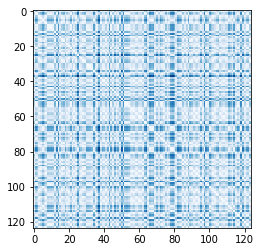

In [20]:
Y = squareform(distance.pdist(sample, DTWDistance))
plt.imshow(Y,interpolation='none',cmap='Blues')

In [22]:
# generate the linkage matrix
Z = linkage(sample, method='single', metric=DTWDistance)

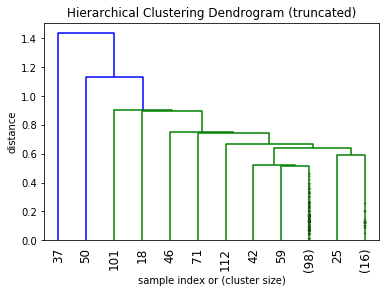

In [23]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [25]:
# set cut-off to 50
max_d = 0.4  # max_d as in max_distance

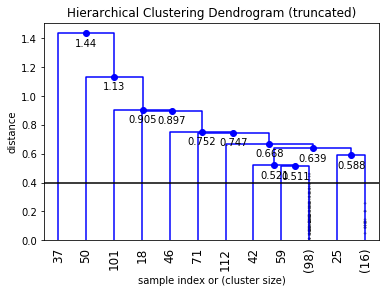

In [26]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above= 0.4,  # useful in small plots so annotations don't overlap
    max_d=max_d,
)
plt.show()

In [27]:
max_d = 0.3
clusters = fcluster(Z, max_d, criterion='distance')
clusters
print("Samples ", len(sample))
n_clusters = np.max(clusters)
print("Clusters found", n_clusters)
clusters

Samples  124
Clusters found 30


array([ 8, 13, 13,  7,  4, 21,  3,  7, 13, 13, 13, 11,  3, 13, 21,  6,  7,
        3, 27, 15,  6, 13,  7,  6,  7, 23,  5,  6,  7,  3, 13, 10, 10,  6,
       21,  6, 13, 30,  7,  5,  6,  7, 20, 22, 13,  7, 26,  6, 13,  3, 29,
       21, 13, 13, 12,  6,  6,  6,  7, 19,  6,  6,  7, 13,  1,  7, 21, 21,
       21,  6, 13, 25, 13, 13,  6,  3,  6,  7, 21, 21, 21,  6,  2, 13, 14,
        7,  6,  7, 13,  3,  7,  6,  7,  7,  6, 13,  6, 21, 13, 13, 21, 28,
        7,  6, 18, 13,  7, 16,  6,  9,  7, 21, 24,  7, 21,  6, 12, 17, 21,
       13,  6, 13, 13,  7], dtype=int32)

In [28]:
codes = []
print("L", L)
w = int(L/2)
classification = []
for i in range(0, len(y_gauss), w):
    window = y_gauss[i:i+w]
    distances = []
    for cluster in avg_clusters:
        d = DTWDistance(window, cluster)
        distances.append(d)
    classification.append(np.argmin(distances))
plt.plot(range(0, len(y), w), classification)
plt.plot(range(0, len(y)), y)

start = 0
end = 0
code = 0
prev_code = classification[0]
codes = []
time = data['time']
classification = np.array(classification).astype(int)
print(classification)
for i in range(len(classification)):
    t = i * w
    code = classification[i]
    change_detected = code != prev_code
    if change_detected:
        codes.append({
            'actor': 'iron',
            'codes': [int(prev_code)],
            'start': time[start],
            'end': time[end]
        })
        start = t
    prev_code = code 
    end = t + w
codes.append({
            'actor': 'iron',
            'codes': [int(prev_code)],
            'start': time[start],
            'end': time[end-w]
        })
print(codes)    
    

L 16


NameError: name 'avg_clusters' is not defined

In [272]:
save_jsonfile('data/sensor_data/acc_coded_cesar.json', codes)

File saved! data/sensor_data/acc_coded_cesar.json
